In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('term-deposit-marketing-2020.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [3]:
print(len(data))
print("Data shape ", data.shape)
describe = data.describe()

40000
Data shape  (40000, 14)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [5]:
print(data.isnull().sum().sort_values(ascending=False))

y            0
campaign     0
duration     0
month        0
day          0
contact      0
loan         0
housing      0
balance      0
default      0
education    0
marital      0
job          0
age          0
dtype: int64


In [6]:
data = data.rename(columns = {"y":"target"})

In [7]:
data["target"] = [1 if i.strip() == "yes" else 0 for i in data.target]

#### Veri Görselleştirme

In [8]:
def bar_plot(variable):
   
    # değişken al
    var = data[variable]
    varVal = var.value_counts()
    
    plt.figure(figsize = (9,3))
    plt.bar(varVal.index, varVal)
    plt.xticks(varVal.index, varVal.index.values)
    plt.ylabel("Freguency")
    plt.title(variable)
    plt.show()
    print ("{} :\n {}".format(variable,varVal))

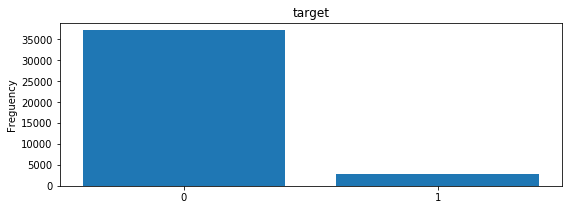

target :
 0    37104
1     2896
Name: target, dtype: int64


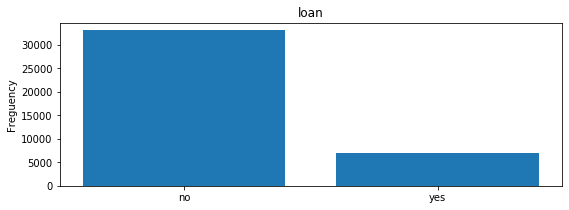

loan :
 no     33070
yes     6930
Name: loan, dtype: int64


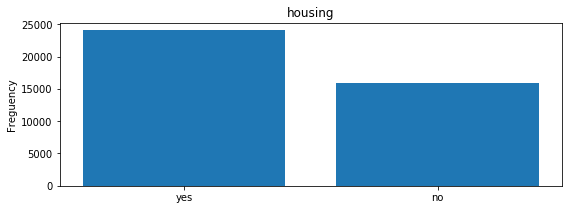

housing :
 yes    24031
no     15969
Name: housing, dtype: int64


In [9]:
category1 = ["target","loan","housing"]
for a in category1:
    bar_plot(a)


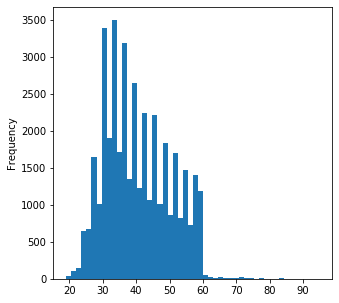

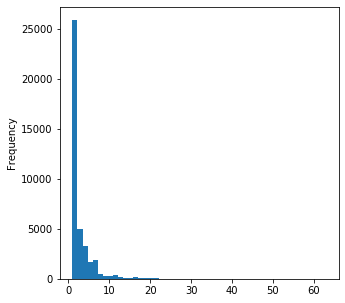

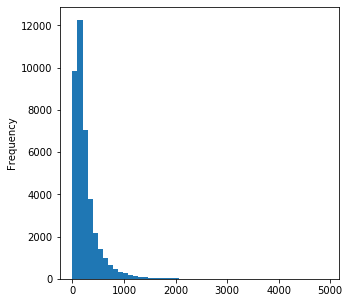

In [10]:
data.age.plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()
data.campaign.plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()
data.duration.plot(kind = 'hist',bins = 50,figsize = (5,5))
plt.show()

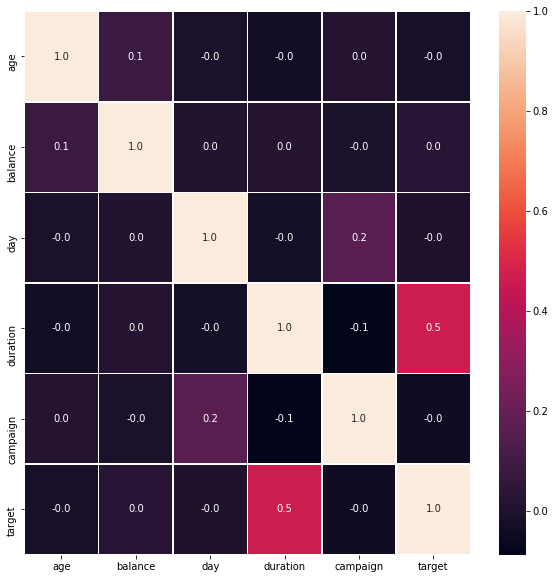

In [11]:
#correlation
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

0.4-0.6 arasında ise orta şiddette korelasyon olduğu için şunu gözlemleyebiliriz duration ve target kolonlarımız arasında orta şiddette bir ilişki vardır.

In [12]:
for col in data.iloc[:,[1, 2, 3, 4, 6, 7, 8, 10]]:
    data[col] = data[col].astype('category')
data.dtypes

age             int64
job          category
marital      category
education    category
default      category
balance         int64
housing      category
loan         category
contact      category
day             int64
month        category
duration        int64
campaign        int64
target          int64
dtype: object

In [13]:
data = pd.get_dummies(data, columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month'], prefix = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month'])
data.head()

,age,balance,day,duration,campaign,target,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,58,2143,5,261,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,44,29,5,151,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,33,2,5,76,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,47,1506,5,92,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,33,1,5,198,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [14]:
y = data.target
x = data.drop(["target"],axis = 1) 

Dataset dengesiz bir dataset olduğu için train_test_split fonksiyonun "stratify" parametresi kullanılmıştır.

In [15]:
test_size = 0.2
X_train, X_test, Y_train, Y_test =  train_test_split(x, y, test_size = test_size, random_state = 42,stratify=y)

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

In [17]:
knn = KNeighborsClassifier(n_neighbors = 2) #neighbors 2 seçildi.
scores = cross_val_score(knn, x, y, cv=5, scoring='accuracy')
print(scores)
print("Accuracy (mean): %",scores.mean()*100)

[0.929   0.928   0.9265  0.92025 0.925  ]
Accuracy (mean): % 92.575


In [18]:
knn = KNeighborsClassifier(n_neighbors = 2) #neighbors 2 seçildi.
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix")
print("CM: ",cm)

result1 = classification_report(Y_test, y_pred)
print("Classification Report:",)
print (result1)

acc = accuracy_score(Y_test, y_pred)
score = knn.score(X_test, Y_test)
print (" ")
y_pred_train= knn.predict(X_train)
acc_train = accuracy_score(Y_train, y_pred_train)
print("Train Score: ",acc_train)
print(" ")
print("Test Score: ",score)

Confusion Matrix
CM:  [[7349   72]
 [ 504   75]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      7421
           1       0.51      0.13      0.21       579

    accuracy                           0.93      8000
   macro avg       0.72      0.56      0.58      8000
weighted avg       0.91      0.93      0.91      8000

 
Train Score:  0.95215625
 
Test Score:  0.928


In [19]:
mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
print('Mean Absolute Error (MAE): %.2f' % mae)
print('Mean Squared Error (MSE): %.2f' % mse)
print('Root Mean Squared Error (RMSE): %.2f' % rmse)

Mean Absolute Error (MAE): 0.07
Mean Squared Error (MSE): 0.07
Root Mean Squared Error (RMSE): 0.27


Ayrıca dataset üzerinde RandomForestClassifier algoritması ile de değerler görülmüştür.

In [20]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 50)
classifier.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
y_pred = classifier.predict(X_test)

In [22]:
result = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:")
print(result)

result1 = classification_report(Y_test, y_pred)
print("Classification Report:",)
print (result1)

result2 = accuracy_score(Y_test,y_pred)
print("Test Accuracy:",result2)
print(" ")
y_ped_train = classifier.predict(X_train)
acc_train = accuracy_score(Y_train, y_pred_train)
print("Train Score: ",acc_train)

Confusion Matrix:
[[7322   99]
 [ 415  164]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7421
           1       0.62      0.28      0.39       579

    accuracy                           0.94      8000
   macro avg       0.78      0.63      0.68      8000
weighted avg       0.92      0.94      0.92      8000

Test Accuracy: 0.93575
 
Train Score:  0.95215625


In [23]:
mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
print('Mean Absolute Error (MAE): %.2f' % mae)
print('Mean Squared Error (MSE): %.2f' % mse)
print('Root Mean Squared Error (RMSE): %.2f' % rmse)

Mean Absolute Error (MAE): 0.06
Mean Squared Error (MSE): 0.06
Root Mean Squared Error (RMSE): 0.25


Modelin oluşturmak için en iyi parametreleri bulmak ve nasıl bir sonuç elde edileceği gözlemlenmesi için KNN_Best_Params fonksiyonu yazılmıştır.

In [24]:
def KNN_Best_Params(x_train, x_test, y_train, y_test):
    
    k_range = list(range(1,5)) #1'den 5'e kadar olan değerler arasındaki en iyi değer bulunmaya çalışılacak
    weight_options = ["uniform","distance"]
    print()
    param_grid = dict(n_neighbors = k_range, weights = weight_options) #gerekli olan parametreler dict içerisine koyuldu.
    
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv = 5, scoring = "accuracy")
    grid.fit(x_train, y_train)
    
    
    print("Best training score: {} with parameters: {}".format(grid.best_score_, grid.best_params_)) 
    #en iyi skor ve en iyi parametre
    print()
    
    #ideal parametrelere ulaşıldığı için test aşamasında kullanılmıştır.
    knn = KNeighborsClassifier(**grid.best_params_)
    knn.fit(x_train, y_train)
    
    y_pred_test = knn.predict(x_test)
    y_pred_train = knn.predict(x_train)
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    acc_test = accuracy_score(y_test, y_pred_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    print("Test Score: {}, Train Score: {}".format(acc_test, acc_train))
    print()
    print("CM Test: ",cm_test)
    print("CM Train: ",cm_train)
    
    return grid
    
    
grid = KNN_Best_Params(X_train, X_test, Y_train, Y_test)
   


Best training score: 0.930125 with parameters: {'n_neighbors': 4, 'weights': 'uniform'}

Test Score: 0.928375, Train Score: 0.94259375

CM Test:  [[7350   71]
 [ 502   77]]
CM Train:  [[29576   107]
 [ 1730   587]]


#### PCA

In [25]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

"""
Yeniden scale edildi çünkü PCA unsupervised bir algoritma bu nedenle tüm x verisi scale edildi.
"""
pca = PCA(n_components = 2) #2 boyuta indirgendi.
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)

X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(X_reduced_pca, y, test_size = test_size, random_state = 42)

grid_pca = KNN_Best_Params(X_train_pca, X_test_pca, Y_train_pca, Y_test_pca)


Best training score: 0.9255624999999998 with parameters: {'n_neighbors': 4, 'weights': 'uniform'}

Test Score: 0.924625, Train Score: 0.9296875

CM Test:  [[7393   31]
 [ 572    4]]
CM Train:  [[29651    29]
 [ 2221    99]]


Sonuç olarak KNN vev Random Forest algoritmaları kullanılarak sınıflandırma yapılmıştır. 
KNN için en iyi parametreleri bulma fonksiyonu değerlendirilmiştir.
Dataset dengesiz olduğu için stratify parametresi ve sadece accuracy yeterli olmayacağı için MAE ve MSE değerleride incelenmiştir.

#### Bonus
Correlation map'te de görüldüğü üzere duration ve target arasında orta şidette bir ilişki var bu sebeple duration üzerinde 
odaklanma sağlanabilir.